the MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. T

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<br> 

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels


In [2]:
X, y = mnist["data"], mnist["target"]
print('\nX.shape: ', X.shape)
print('\ny.shape: ', y.shape)


X.shape:  (70000, 784)

y.shape:  (70000,)


<br>

##### visualise a digit from the dataset

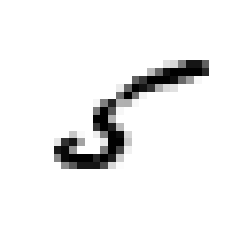

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X.to_numpy()[11,:] # 12 th instance
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


* the label provided for this instance is :

In [4]:
y.to_numpy()[11]

'5'

<br>

> labels are strings, converting them to number type :


In [5]:
import numpy as np
y = y.astype(np.uint8)
y[:3]

0    5
1    0
2    4
Name: class, dtype: uint8

<br>

> The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images), although i'm re-splitting it in a stratified manner 


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=77 )
for train_index, test_index in split.split(X, y):
    train_set_x = X.loc[train_index]
    train_set_y = y.loc[train_index]
    test_set_x = X.loc[test_index]
    test_set_y = y.loc[test_index]


<br> 

### stratified splitting result: same values ratio in all sets

In [7]:
feature = 5

print(" '"+str(feature)+"' label in test set  : ",len(test_set_x[test_set_y==feature])/len(test_set_y) )
print(" '"+str(feature)+"' label in train set  : ",len(train_set_x[train_set_y==feature])/len(train_set_y) )

print(" '"+str(feature)+"' label in the main set (X,y):  ", len(X[y==feature])/len(X))

# the two values are slightly the same, the difference is due to the small dataset i used  (same for other labels)

 '5' label in test set  :  0.09021428571428572
 '5' label in train set  :  0.09017857142857143
 '5' label in the main set (X,y):   0.09018571428571429


<br>

### Create a Binary classifier 

In [8]:
y_train_5 = (train_set_y == 5) # True for all 5s, False for all other digits.
y_test_5 = (test_set_y == 5)

In [9]:
y_test_5[:3]

21747    False
66483     True
36671    False
Name: class, dtype: bool

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_set_x, y_train_5)


SGDClassifier(random_state=42)

 <br>
 
 
 Let's see if the following 2 drawn digits are classified as the digit 5
 

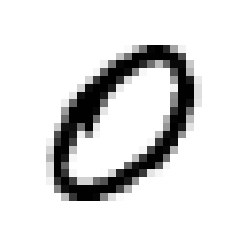

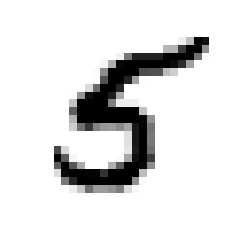

In [11]:
drawn_digit1 = test_set_x.iloc[0,:].to_numpy()
drawn_digit2 = test_set_x.iloc[1,:].to_numpy()
some_digit_image1 = drawn_digit1.reshape(28, 28)
some_digit_image2 = drawn_digit2.reshape(28, 28)
plt.imshow(some_digit_image1, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
plt.imshow(some_digit_image2, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
sgd_clf.predict( [drawn_digit1, drawn_digit2]  )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False,  True])

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

<br>

## Measuring accuracy : Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

> The accuracy is very high because only 10% of the data has a 5 digit label (True), the following is an object that represents a classifier that is allways classifies every input as non 5 digit

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


> if we pass same trainning data, we'll get the same output as the SGDClassifier model  

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

<br> 

### Conclusion

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).



<br>

## Confusion Matrix 
better way to evaluate the performance of a classifier


 cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* 53 892 (0,0 : index) : true negatives, instances classified correctly as non-5s
* 687 (1,0 : index) : false positives, instances classified wrongly as 5s digits
* 1891 (0,1 : index) : false negatives, instances classified wrongly as non-5s digits
* 3530 (1,1 : index) : true positives, instances classified correctly as 5s digits

> A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

<br>

* accuracy of positive predictions , aka precision  :  precision = TP/(TP + FP)
* True positive rate (TPR) = Sensitivity = recall  = TP/(TP+FN)
                

In [19]:
from sklearn.metrics import precision_score, recall_score
print( "precision: ", precision_score(y_train_5, y_train_pred), "\n")  # the precision is less shinny as the last time
print( "recall: ", recall_score(y_train_5, y_train_pred)  )

precision:  0.8370879772350012 

recall:  0.6511713705958311


> combinning these two measures : the harmonic mean of precision and recall (F1)  :

    F1 = 2 * ( (Precision*Recall)(Precision+Recall) ) 
    
> The higher F1, the higher precision & recall 

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846